
# ACH2016 - Inteligência Artificial

### Rubens Victor Gomes 8598878 <br> Higor 22222222 ### 

[Kmeans](#kmeans)<br>
Kmeans ++<br>
Small dataset pre processing<br>
Binary<br>
Tf-Df<br>
Tf-Idf<br>
Big dataset pre processing<br>
[Visualization of the clusters](#visualization)<br>
[Silhouette visualization](#visualization) <br>
Silhouette implementation<br>
Elbow Method<br>
IEEE Report<br>

In [1]:
#Importing the dependencies
import re, string, unicodedata, itertools, random, os, glob, math
import pickle
import nltk
from nltk import SnowballStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial import distance_matrix
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer


from __future__ import print_function
print(__doc__)

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = (24, 9)
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to /home/rgomes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Automatically created module for IPython interactive environment


In [28]:
# LOAD THE DATASET
print('reading...')
X = np.loadtxt('tf_matrix_normalized.txt')
print('loaded')
print(X.shape)
print(X[0])

reading...
loaded
(1255, 12187)
[0. 0. 0. ... 0. 0. 0.]


In [4]:
# Centroids initializations
# @method
# 'zeros' initialize with zeros
# 'random' pick k random datapoints
# 'k-means++' pick the first random, then pick k - 1 datapoints that maximizes the D² between them
def initializeCentroid(X, K, method):
    centroids = []
        
    # maxime the squared distance of centroids
    # 1.Choose one center uniformly at random from among the data points.
    # 2.For each data point x, compute D(x), the distance between x and the nearest center that has already been chosen.
    # 3.Choose one new data point at random as a new center, 
    # using a weighted probability distribution where a point x is chosen with probability proportional to D(x)2.
    # 4.Repeat Steps 2 and 3 until k centers have been chosen.
    if method == 'k-means++':
        #primeiro centroide (aleatorio)
        centroids = np.zeros((K, X.shape[1]))
        centroids[0] = X[np.random.choice(X.shape[0], 1)]
        
        num_instances, num_features = X.shape
        
        #enquanto nao tiver K centroides
        for z in range(1,K):
            D2 = []
            prob = []
            cumprob = []
        
            #calcula matriz de distancia
            dist_matrix = distance_matrix(X, centroids)
        
            for i in np.arange(num_instances):
                # finding the closest centroid
                d = dist_matrix[i]
                D2.append((np.where(d == np.min(d)))[0][0])
        
            #faz a soma das probabilidades
            for i in np.arange(num_instances):
                prob.append(D2[i]/sum(D2))
        
            #gera a probabilidade acumulada e escolhe o centroide
            for i in np.arange(num_instances):
                somacum = 0
                for j in range(0,i):
                    somacum += prob[j]
                cumprob.append(somacum)
                
            rn = random.random()
            ind = 0
            for i in np.arange(num_instances):
                if(cumprob[i] >= rn):
                    ind = i
                    break
                
            centroids[z] = X[ind]
            
    if method == 'random':
        centroids = X[np.random.choice(X.shape[0], K)]
        
    return centroids
    

**KMeans** (__iterations__ :
Max number of iterations, _default 300_, 
__distance__,
Type of distance metric, _default euclidian_
__method__,
Initialization method: 'random', 'k-means++')
<a id="kmeans"></a>

In [5]:
def closest_centroid(point, centroids):
    min_distance = float('inf')
    belongs_to_cluster = None
    for j, centroid in enumerate(centroids):
        dist = np.sqrt(np.sum((point-centroid)**2))
        if dist < min_distance:
            min_distance = dist
            belongs_to_cluster = j

    return belongs_to_cluster

In [61]:
def equals(centroids_old, centroids_new):
    for i in range (len(centroids_old)):
        point1 = centroids_old[i]
        centroids_new = centroids_new[i]
        if (centroids_old != centroids_new).any():
            return False

    return True

In [62]:
def kMeans(X, K, max_iterations, method):
    
    num_instances, num_features = X.shape
    
    # Initialize the centroids
    # Pick k random points to use as our initial centroids    
    initial_centroids = initializeCentroid(X,K,method)
    
    centroids = initial_centroids
    
    centroids_old = np.zeros(centroids.shape)
    
    # this may cause the centroids start on a good stop and converge faster
    # so its important to run 30 times and take the avg
    clusters = [initializeCentroid(X,1, 'random') for i in range(K)]
    
    cluster_labels = np.zeros(num_instances)
    
    iterations = 1
    while not equals(centroids_old, centroids) and iterations < max_iterations:
        # make the new centroids the current
        centroids_old = centroids.copy()
        
        # for each point in X
        for idx in np.arange(num_instances):
        
            # assign to the closest centroid
            label = closest_centroid(X[idx], centroids)
            np.append(X[idx], clusters[label])
            cluster_labels[idx] = label

        centroids = [np.mean(cluster, axis=0) for cluster in clusters]
        iterations += 1

    return np.array(centroids), np.array(cluster_labels), iterations

In [63]:
def silhouette(X,clusters):
    dist_matrix = distance_matrix(X,X)
    num_instances = X.shape[0]
    print(num_instances)
    a_array = np.zeros(num_instances)
    b_array = np.zeros(num_instances)
    b_array += np.inf
    groups_number = np.unique(clusters)
    num_clusters = groups_number.shape[0]

    for i in groups_number:
        group_filter = clusters == i
        group_matrix = dist_matrix[group_filter,:]
        group_matrix = group_matrix[:,group_filter]
        a_array[group_filter] = np.sum(group_matrix,axis=1)/(group_matrix[:,0].size-1)

        for c in groups_number:
            if c != i:
                neighbor_group_filter = clusters == c
                neighbor_group_matrix = dist_matrix[group_filter,:]
                neighbor_group_matrix = neighbor_group_matrix[:,neighbor_group_filter]
                neighbor_distances_array = np.mean(neighbor_group_matrix,axis=1)
                b_array[group_filter] = np.minimum(b_array[group_filter], neighbor_distances_array)
    
    silhouette_array = b_array - a_array
    silhouette_array /= np.maximum(a_array,b_array)
    return np.mean(silhouette_array)

DATASET (1255, 12187)
took 100 iterations
My KMeans
For n_clusters = 10 The average silhouette_score is : 0.01644306191110508
took 100 iterations
My KMeans
For n_clusters = 20 The average silhouette_score is : 0.022938623436035744
took 100 iterations
My KMeans
For n_clusters = 50 The average silhouette_score is : 0.05934040691650463


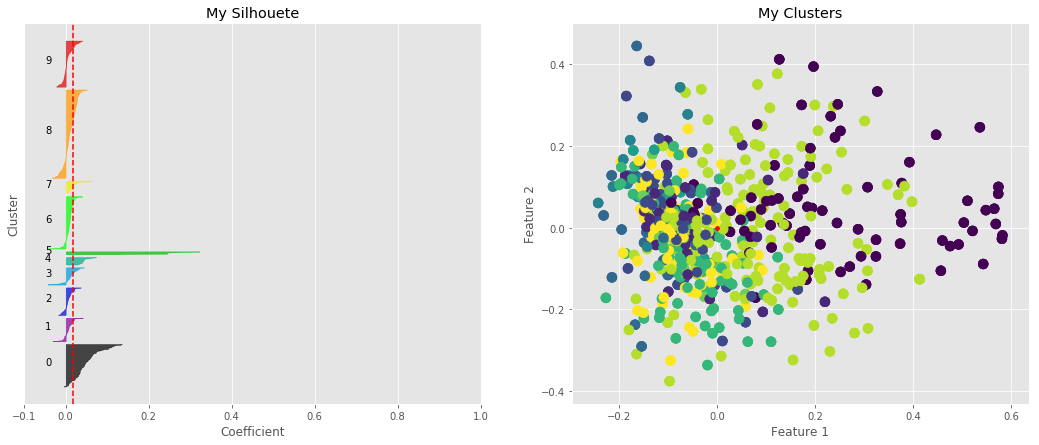

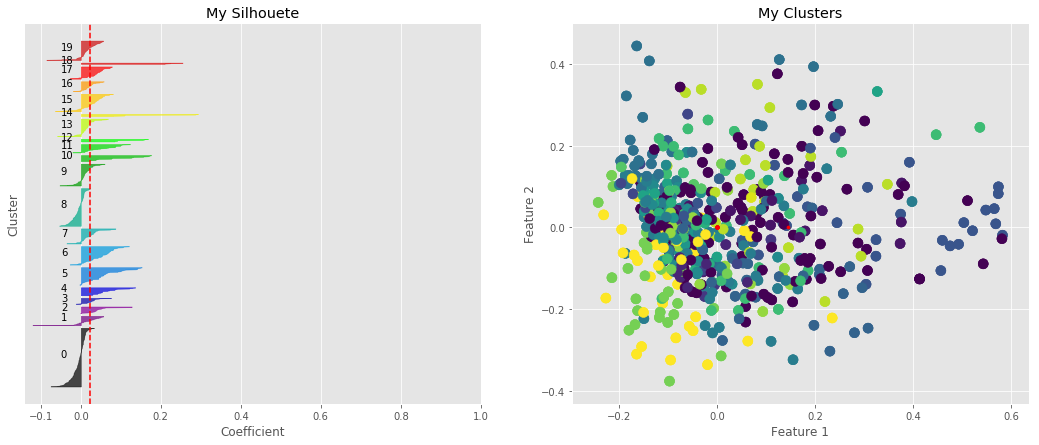

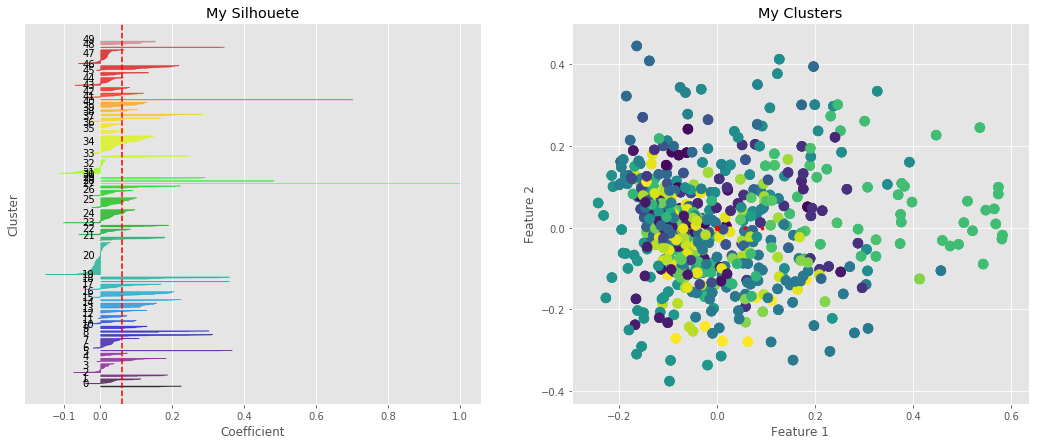

In [64]:
print('DATASET', X.shape)

range_n_clusters = [10, 20, 50]

for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax3, ax4) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    #-------------------------------------------------------------------------------------------------------------#
    
     # My kMeans implementation
    centroids, cluster_labels, iterations = kMeans(X, K=n_clusters, max_iterations=3, method='k-means++')
    
    print('took', iterations, 'iterations')
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    #silhouette_avg = silhouette(X, cluster_labels)
 

    print("My KMeans")
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax3.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax3.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax3.set_title("My Silhouete")
    ax3.set_xlabel("Coefficient")
    ax3.set_ylabel("Cluster")

    # The vertical line for average silhouette score of all the values
    ax3.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax3.set_yticks([])  # Clear the yaxis labels / ticks
    ax3.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    

    # ----------------- My clusters --------------------------------

    # REDUCE TO 2 COMPONENTS
    pca = PCA(n_components=2)
    pca.fit(X)
    pca_score = pca.explained_variance_ratio_
    Y = pca.fit_transform(X)

    colors = cm.spectral(len(cluster_labels) / n_clusters)

    ax4.scatter(Y[:, 0], Y[:,1], s = 100, c = cluster_labels)
    ax4.scatter(centroids[:, 0], centroids[:, 1], s = 10, c = 'red',label = 'Centroids')

    ax4.set_title("My Clusters")
    ax4.set_xlabel("Feature 1")
    ax4.set_ylabel("Feature 2")   
    
plt.show()